
<div style='width:100%; background: #417DB0;padding-top:50px; padding-bottom:50px;border-top: 20px solid #B6D4AE;border-bottom: 20px solid #B6D4AE'>
    <div style='font-size:30px;font-weight:bold; color:white; margin-bottom:40px;text-align:center'>
        Semantic Halo of Meter in Czech Poetry
    </div>
    <div style='text-align:center; color:white'>
        Petr Plecháč, Robert Kolár
    </div>
</div>



In [10]:
#----------------------------------------------------------------------------------------------------------
# We are given two objects in JSON 
#----------------------------------------------------------------------------------------------------------
# {dir: corpora}
# data = [   <= each item corresponds to particular poem and comprise 100-dimensional dict
#     {
#     'topic title': its probability in poem
#     }
# ]
#----------------------------------------------------------------------------------------------------------
# {dir: json/metadata}
# metadata = {        <= Each item in following lists corresponds to particular poem and holds: 
#     'meters': [[]]      <= list of meters found in poem
#     'years': []         <= year when poem published (year when author born in case of English)
#     'n_words': []       <= number of words
#     'n_lines': []       <= number of lines
#     'authors': []       <= author of the poem
#     'titles': []        <= title of the poem
# }
#----------------------------------------------------------------------------------------------------------

import json
import os
import re
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt 
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
import seaborn as sns
from collections import defaultdict
from pca import pca
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
from functools import reduce
from matplotlib.lines import Line2D
from functools import reduce
from scipy import stats

# Create "fig" folder if not existing yet
if not os.path.exists('fig'):
    os.makedirs('fig')

# Style boxplots
boxprops = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':(1,1,1,0)}
}

<h3>Select models</h3>
Here one may select between different models

In [11]:
window    = 5                              # word2vec - maximum distance between current and predicted word
size      = 100                            # word2vec - dimensionality of the vector space
min_count = 1                              # word2vec - ignore all words with frequency lower than this
max_nn    = 10                             # LDA - max nearest neighbours taken into account when substituting words
mft       = 1000                           # LDA - level of most frequent words taken into account
n_topics  = 100                            # LDA - number of topics

<h3>Set parameters</h3>


In [12]:
params = {
    # Drop all poems line-counts of which do not fall into the following interval (left-closed, right-opened)
    'poem_range': (4,101)
}

<h3>Build dataframe</h3>
First we load data from JSON files and store them into dataframe (poems x topics) with multiindex comprising various metadata.

In [13]:
# Load data on topics
with open ('json/topics/cs_w-{0}_s-{1}_m-{2}_nn-{3}_mft-{4}_t-{5}.json'.format(
    window, size, min_count, max_nn, mft, n_topics
)) as file:
    data = json.load(file)
        
# Load metadata on poems:
with open (os.path.join('json', 'metadata', '{}.json'.format('cs'))) as file:
    metadata = json.load(file)
    
# Basic info on corpora
print('# of texts: ', len(metadata['titles']))
print('# of lines: ', sum(metadata['n_lines']))
print('# of tokens:', sum(metadata['n_words']))
        
# Filter out polymetric poems
m_families = list()
for i,m in enumerate(metadata['meters']):
    met = ''.join(sorted([re.sub('[0-9]+', '', x) for x in m]))
    met = re.sub('I+', 'I', met)
    met = re.sub('T+', 'T', met)   
    if met in ('I', 'T'):
        m_families.append(met)
    else:
        m_families.append('other')
    metadata['meters'][i] = '_'.join(metadata['meters'][i])
    
# Build multiindex comprising metadata
index = pd.MultiIndex.from_arrays([ 
    range(len(metadata['meters'])),
    metadata['meters'], metadata['years'], metadata['n_words'], 
    metadata['n_lines'], metadata['authors'], metadata['titles'], m_families
], names = ('id', 'meters', 'years', 'n_words', 'n_lines', 'authors', 'titles', 'm_families'))

# Build dataframe
df = pd.DataFrame(data, index=index).fillna(0)

# Delete poems length of which is outside the requested interval
df = df[df.index.get_level_values('n_lines').isin(range(
    params['poem_range'][0], params['poem_range'][1]
))]
                                       

# of texts:  70170
# of lines:  2400166
# of tokens: 13152227


<h3>Show topics</h3>
Print out topics (represented by their top 5 words) in each corpus.

In [14]:
topics_dict = dict()

for topic in list(df.columns):
    idx = re.sub(r'^\(([0-9]*)\).*$', r'\1', topic)
    name = re.sub('^\([0-9]*\) *', '', topic)
    topics_dict[int(idx)+1] = name

for idx in sorted(topics_dict):
    print('{} {}'.format(str(idx).zfill(3), topics_dict[idx]))   
    # Or formatted as LaTeX table
    #print('{} & {} & \\\\'.format(str(idx).zfill(3), topics_dict[idx]))

001 rok - čas - doba - den - dlouhý
002 žena - muž - družka - mladý - krásný
003 les - strom - větev - mech - tráva
004 říci - ptát - vědět - povědět - dít
005 hlad - bída - chudý - chléb - bídný
006 boží - Kristus - anděl - kříž - panna
007 hrob - mrtvý - rakev - ležet - smrt
008 zvolat - tvář - velký - stát - síň
009 pán - pan - věc - moudrý - rada
010 boj - vojsko - meč - zbraň - rek
011 hrát - smát - tančit - hra - kolo
012 dlít - modlit - prosit - modlitba - nosit
013 krásný - kvítek - háj - sladký - slunko
014 svět - celý - jiný - umět - znát
015 voda - řeka - jezero - proud - břeh
016 kůň - hnát - běžet - skok - jet
017 pes - jet - vůz - zub - kost
018 milovat - svatý - učit - milenec - znát
019 prach - déšť - kámen - padat - krůpěj
020 kraj - cizí - vrátit - domov - rodný
021 noc - tma - měsíc - světlo - luna
022 moci - muset - lze - smět - možný
023 sen - mládí - snít - pohádka - duše
024 slovo - jediný - mluvit - němý - řeč
025 pít - víno - číše - číš - pohár
026 sníh - mráz 

<h2 style="padding-top:15px; margin-top:30px;border-top:5px solid #417DB0">Topic distribution across generations</h2>

<h3>Functions</h3>

In [15]:
def zscore_transformation(df):
    '''
    Transform dataset to zscores
    :df = [dataframe] dataset
    '''
    
    df = (df - df.mean())/df.std(ddof=0)
    return df.fillna(0)
    
def plot_dendrogram(df, metric, method, level, figsize=(10,5), zscore=True, colors=None, 
                    labelsize=None, filename=None, legend=None, cluster_labels=False):
    '''
    Function to plot dendrograms
    :df             = [dataframe] dataset (labels-multiindex x features)
    :metric         = [string]    metric to be used in dendrogram
    :method         = [string]    clustering method to be used in dendrogram
    :level          = [string]    which level of multiindex to use for leave-labels
    :figsize        = [set]       size of the figure (w x h)
    :zscore         = [bool]      whether to transform the dataset to zscores
    :colors         = [dict]      dict holding predefined leave colors
    :labelsize      = [int]       font size of y-axis labels
    :filename       = [string]    name of the output file
    :legend         = [list]      list of items for legend (when colors != None)
    :cluster_labels = [dict]      cluster labels given as a dict of {x-coords, y-coords, colors, text, fontsize}
    '''
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    # Extract labels
    labels = list(df.index.get_level_values(level))
        
    # Transform to zscores if required
    if zscore:
        df = zscore_transformation(df)
    # Linkage matrix
    c_link = linkage(df, metric=metric, method=method)
    # Plot dendrogram
    ddata = dendrogram(c_link,labels=labels, orientation='left', color_threshold=0, above_threshold_color='k')
    # Color coding leaves
    if colors:
        ylbls = ax.get_ymajorticklabels()
        for lbl in ylbls:
            bbox = dict(boxstyle="round", ec=colors[lbl.get_text()], fc=colors[lbl.get_text()], alpha=0.7)
            plt.setp(lbl, bbox=bbox)
    # Adjust font size
    if labelsize:
        ax.tick_params(axis='y', which='major', labelsize=labelsize)
    # Create legend
    if legend:
        custom_legend = []
        for col,type_ in zip(legend[1], legend[2]):
            if type_ == 'bbox':
                custom_legend.append(Line2D([0], [0], color=col, lw=8))
            elif type_ == 'circle':
                 custom_legend.append(
                     Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=col, markersize=12)
                 )
       
        ax.legend(custom_legend, [x for x in legend[0]], loc=2)
    # Cluster labels
    if cluster_labels:
        for x, y, col, label in zip(
            cluster_labels['x'], cluster_labels['y'], cluster_labels['colors'],  cluster_labels['text']
        ):
            plt.plot(x, y, color=col, marker='o', markersize=cluster_labels['fontsize']+5)
            plt.annotate(label, (x, y-1), xytext=(0, 0), textcoords='offset pixels', va='center', 
                         ha='center', color='w', fontsize=cluster_labels['fontsize'])         
    # Save figure
    if filename:
        plt.tight_layout()
        fig.savefig('fig/{}.pdf'.format(filename), dpi="figure")


<h3>General settings</h3>

In [16]:
# Define author groups
authors = {
    'LUM': [ 'Kučera, Karel', 'Kvapil, František', 'Vrchlický, Jaroslav', 
            'Sládek, Josef Václav', 'Zeyer, Julius', 'Klášterský, Antonín'],
    'RUC': ['Krásnohorská, Eliška', 'Pokorný, Rudolf', 'Čech, Svatopluk', 'Quis, Ladislav'],
    'DEC': ['Auředníček, Otakar', 'Borecký, Jaromír', 'Hašek, Roman', 'Rožek, Karel', 
            'Hendrych, Jaroslav', 'Nejč, Karel', 'Ráž, Arnošt', 'Bíbl, František',
            'Gintl, Zdeněk', 'Rosenzweig-Moir, Josef', 'Karásek ze Lvovic, Jiří', 'Březina, Otokar', 
            'Hlaváček, Karel'],
    'POS': ['Toman, Karel', 'Gellner, František', 'Šrámek, Fráňa', 'Dyk, Viktor'],
}

# Print number of poems by particular authors and a total number of poems
total = 0
for group in authors:
    for author in authors[group]:
        dfa = df[df.index.get_level_values('authors') == author] 
        print(group, author, '::', len(dfa.index), 'poems')
        total += len(dfa.index)
print('{}\nTOTAL: {}'.format('-'*40, total))

LUM Kučera, Karel :: 31 poems
LUM Kvapil, František :: 238 poems
LUM Vrchlický, Jaroslav :: 5683 poems
LUM Sládek, Josef Václav :: 840 poems
LUM Zeyer, Julius :: 47 poems
LUM Klášterský, Antonín :: 1609 poems
RUC Krásnohorská, Eliška :: 496 poems
RUC Pokorný, Rudolf :: 609 poems
RUC Čech, Svatopluk :: 302 poems
RUC Quis, Ladislav :: 452 poems
DEC Auředníček, Otakar :: 103 poems
DEC Borecký, Jaromír :: 173 poems
DEC Hašek, Roman :: 79 poems
DEC Rožek, Karel :: 90 poems
DEC Hendrych, Jaroslav :: 64 poems
DEC Nejč, Karel :: 17 poems
DEC Ráž, Arnošt :: 84 poems
DEC Bíbl, František :: 138 poems
DEC Gintl, Zdeněk :: 32 poems
DEC Rosenzweig-Moir, Josef :: 60 poems
DEC Karásek ze Lvovic, Jiří :: 341 poems
DEC Březina, Otokar :: 153 poems
DEC Hlaváček, Karel :: 72 poems
POS Toman, Karel :: 156 poems
POS Gellner, František :: 265 poems
POS Šrámek, Fráňa :: 253 poems
POS Dyk, Viktor :: 987 poems
----------------------------------------
TOTAL: 13374


<h3>Dendrogram (authors x topics)</h3>

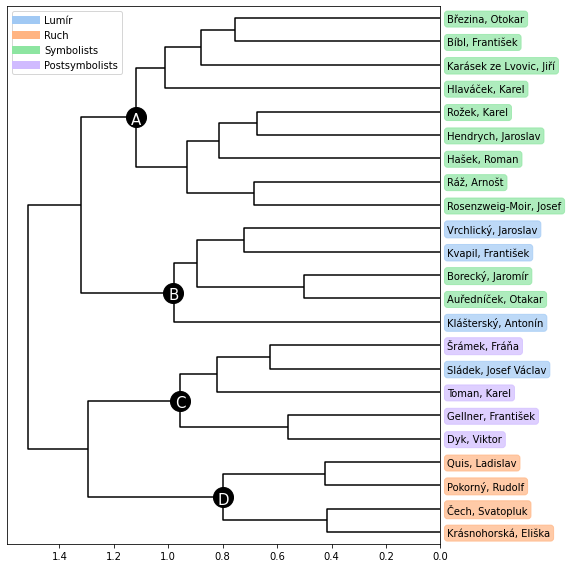

In [17]:
author_labels = list()
for group in authors:
    for a in authors[group]:
        author_labels.append(a)

# Keep only poems by selected authors
dfa = df[df.index.get_level_values('authors').isin(author_labels)] 
# Reduce to authors having more than 50 poems
count = dfa.iloc[:,0].groupby(['authors']).count()
count = count[count >= 50]        
dfa = dfa[dfa.index.get_level_values('authors').isin([x for x in count.index])]
# Get mean values
dfa = dfa.groupby(['authors']).mean()

# Set color coding
colors = {'LUM': '#a1c9f4', 'RUC': '#ffb482', 'DEC': '#8de5a1', 'POS': '#d0bbff'}
legend = [
    ['Lumír', 'Ruch', 'Symbolists', 'Postsymbolists'], 
    ['#a1c9f4', '#ffb482', '#8de5a1', '#d0bbff'],
    ['bbox', 'bbox', 'bbox', 'bbox']
]
cols = dict()
aa = list(dfa.index)
for i,a in enumerate(aa):
    for group in authors:
        if a in authors[group]:
            cols[a] = colors[group]

# Custom labels for main clusters
cluster_labels = {
    'x':    (0.798, 0.956, 0.981, 1.12),
    'y':    (20, 61.25, 107.5, 182.5),
    'colors': ['black'] * 4,
    'text': ('D', 'C', 'B', 'A'),
    'fontsize': 15,
}           
            
# Plot dendrogram
plot_dendrogram(
    df=dfa, metric='cosine', method='complete', level='authors', 
    zscore=True, colors=cols, figsize=(8,8), filename='topics_generations', 
    legend=legend, cluster_labels=cluster_labels
)

<h3>SVM - group (generation) recognition based on topics</h3>

In [455]:
def svm_all(n_samples=10, sample_size=10, iterations=100, fi=True, min_n=0):
    '''
    Perform SVM classification (classes: groups, features: topics)
    
    Arguments:
    ==========
    n_samples    = (int)  Number of random samples per each author (default 10)
    sample_size  = (int)  Number of poems in each sample (default 10)
    iterations   = (int)  Number of iterations when random sampling is performed (default=100)
    fi           = (bool) Whether to extract feature importances
    min_n        = (int)  Include only authors having more than this number of poems (0: include all)
    
    Returns:
    ========
    accuracy     = (list) of accuracy estimations from each iteration LOO cross-validation
    decisions    = (dict) holding confusion matrices
    importances  = (dict) holding feature importances from each iteration
    '''

    # Bins to store accuracy scores, SVM decisions and feature importances
    accuracy    = list()
    decisions   = defaultdict(lambda: defaultdict(int))
    importances = defaultdict(list)

    # Perform requested number of iterations
    for iteration in range(iterations):
        print('{}/{}{}'.format(iteration+1, iterations, ' '*20), end='\r')

        #
        # Sampling
        #

        # Bin to store author samples
        samples = list()

        # Iterate over meters
        for author in author_labels:

            # Keep only poems by current author
            df_single = df[df.index.get_level_values('authors') == author]

            # Skip if less than required number of samples
            if min_n > 0 and min_n > len(df_single.index):
                continue
            
            # Shuffle dataframe
            df_single = df_single.sample(frac=1)

            # Iteratively extract samples
            for i in range(n_samples):
                # Break if not enough data to create another sample
                if (i+1)*sample_size >= len(df_single.index) + 1:
                    break
                # Extract sample
                sample = df_single[i*sample_size:(i+1)*sample_size]
                # Average the values in sample
                sample_mean = sample.groupby(['authors']).mean()
                # Add sample to the list
                samples.append(sample_mean)                

        # Concat samples into single dataframe
        dfa = pd.concat([x for x in samples])
        # Reindex the dataframe (keep authors only)
        dfa.index = dfa.index.get_level_values(0)
        # Transform dataframe to zscores
        dfa = zscore_transformation(dfa)

        #
        # Classification
        #

        # Initialize the classifier
        clf = SVC(kernel='linear', C=1)

        # Get numpy array holding vectors (X) and corresponding classes (y)
        X = dfa.values
        y = list(dfa.index.get_level_values('authors'))
        y = ['LUM' if x in authors['LUM'] else x for x in y]
        y = ['RUC' if x in authors['RUC'] else x for x in y]
        y = ['DEC' if x in authors['DEC'] else x for x in y]
        y = ['POS' if x in authors['POS'] else x for x in y]

        # Get leave one out splits
        loo = LeaveOneOut()
        loo.get_n_splits(X)

        # Bin to store number of successes / trials
        suc_trials = [0,0]

        # Iterate over loo splits
        for train_index, test_index in loo.split(X):
            # Split to train set and test set
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
            # Train the model
            clf.fit(X_train, y_train)
            # Perform classification
            predicted = clf.predict(X_test)
            # Increase the number of trials
            suc_trials[1] += 1
            # Increase the number of successes if classification correct
            if predicted[0] == y_test[0]:
                suc_trials[0] += 1
            # Add decision to the list
            auth = list(dfa.index.get_level_values('authors'))[test_index[0]]
            count = len(dfa[dfa.index.get_level_values('authors') == auth].index)
            decisions[predicted[0]][auth] += 1/(count*iterations)

        # Calculate accuracy in current iteration
        acc = suc_trials[0]/suc_trials[1]
        # Append accuracy to the bin
        accuracy.append(acc)

        #
        # Feature importances
        #

        if fi:
            for class_ in set(y):
                y_ = [x if x == class_ else 'X-REST' for x in y]    
                model = clf.fit(X, np.array(y_))
                dfi = pd.Series(list(model.coef_[0]), list(dfa.columns))
                importances[class_].append(dfi)

    if fi:
        return accuracy, decisions, importances
    else:
        return accuracy, decisions

def plot_confusion_matrix(decisions):
    '''
    Plot confusion matrix with data produced by svm_all()
    '''
    
    confusion_matrix = pd.DataFrame(decisions)
    # Prepend group to author
    aa = list(confusion_matrix.index)
    for i,a in enumerate(aa):
        for group in authors:
            if a in authors[group]:
                aa[i] = group + ' ' + aa[i]
    confusion_matrix.index = pd.Index(aa)
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(
        confusion_matrix.sort_index(axis=1).sort_index(axis=0), annot=True, cbar=False, cmap="PuBuGn"
    )
    
def print_feature_importances(importances, n=5):
    '''
    Print most important feature for each class based on data produced by svm_all()
    '''
    
    for group in importances:
        print('{0}\n{1}\n{0}'.format('-'*10, group))
        fi = reduce(
            lambda a, b: a.add(b, fill_value=0), importances[group]).div(len(importances[group])
        ).sort_values()
        print(fi[:n])

SAMPLE SIZE: 1     ACC(mean): 0.3942    ACC(std): 0.0646
SAMPLE SIZE: 2     ACC(mean): 0.4827    ACC(std): 0.0671
SAMPLE SIZE: 3     ACC(mean): 0.5528    ACC(std): 0.0672
SAMPLE SIZE: 4     ACC(mean): 0.6079    ACC(std): 0.0656
SAMPLE SIZE: 5     ACC(mean): 0.6537    ACC(std): 0.0657
SAMPLE SIZE: 10    ACC(mean): 0.795    ACC(std): 0.054
SAMPLE SIZE: 15    ACC(mean): 0.8696    ACC(std): 0.0441
SAMPLE SIZE: 20    ACC(mean): 0.913    ACC(std): 0.0363
----------
DEC
----------
(82) plamen - oheň - žhavý - krev - žár               -0.125427
(35) stín - duše - večer - mlha - šero                -0.113852
(89) duše - smutek - bolest - smutný - srdce          -0.098035
(49) prostor - tajemný - věčnost - země - tajemství   -0.095933
(94) perla - zlatý - víla - ňadro - květ              -0.085208
dtype: float64
----------
RUC
----------
(51) oko - tvář - slovo - temný - hled         -0.125205
(77) vlast - český - Čech - národ - Čechy      -0.108008
(12) krásný - kvítek - háj - sladký - slunko  

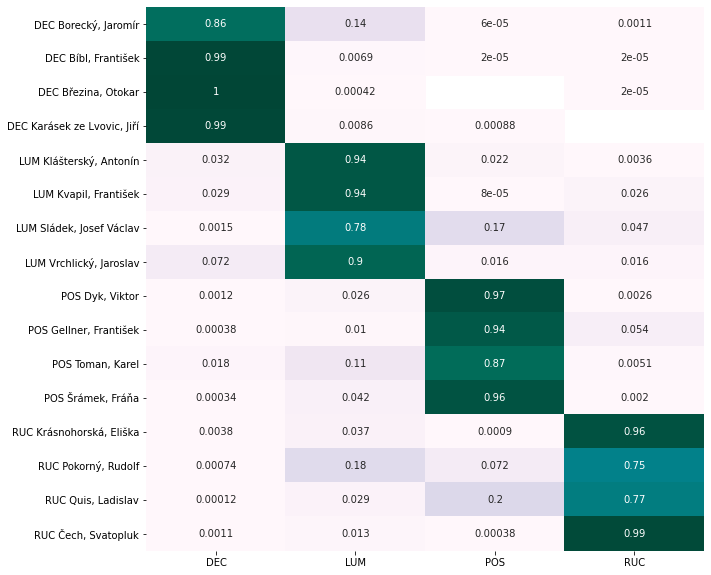

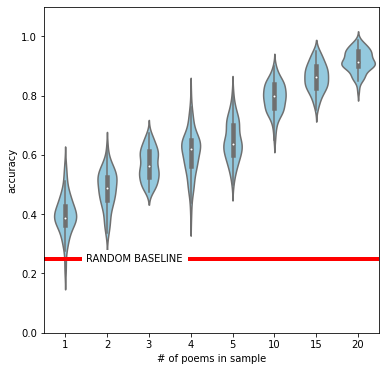

In [457]:
# 
# SVM classification (different sample sizes)
# 

# Bin to store accuracies
accs = []
# Sample sizes
x_ticks = [1,2,3,4,5,10,15,20]
# Random baseline (to be plotted in the chart)
random_baseline = 0.25

# Iterate over different sample sizes
for sample_size in x_ticks:
    # Perform requested number of loo cvs
    accuracy, decisions = svm_all(min_n=120, n_samples=5, sample_size=sample_size, fi=False, iterations=10000)
    # Add accuracies to the bin
    accs.extend([[a, sample_size] for a in accuracy])
    # Print mean and std.dev of accuracy values
    print('SAMPLE SIZE: {}    ACC(mean): {}    ACC(std): {}'.format(
        str(sample_size).ljust(2), round(np.mean(accuracy), 4), round(np.std(accuracy), 4)
    ))
    if sample_size == 20:
        # Plot confusion matrix
        plot_confusion_matrix(decisions)
        # Print feature importances
        print_feature_importances(importances)
    
# Violin plot
dfa = pd.DataFrame(accs_sns, columns=['val', 'size'])
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
ax = sns.violinplot(x="size", y="val", data=dfa, color='skyblue')
ax1.set_ylim([0,1.1])
ax1.set_ylabel('accuracy')
ax1.set_xlabel('# of poems in sample')
plt.axhline(linewidth=4, y=rb, color='red')
plt.text(0.5, rb, 'RANDOM BASELINE', fontsize=10, va='center', ha='left', backgroundcolor='w')
fig.savefig('fig/svm1-violin.pdf')
plt.show(); 

<h2 style="padding-top:15px; margin-top:30px;border-top:5px solid #417DB0">Meter-topic relations</h2>

<h3>General info</h3>

In [464]:
# Dict to store poem counts in particular meters by each group
counts = defaultdict(lambda: defaultdict(int))
# Iterate over groups
for group in authors:
    # Limit df to poems of current group
    dfa = df[df.index.get_level_values('authors').isin(authors[group])] 
    # Count poems in particular meters
    for m in ('I', 'T'):
        dfm = dfa[dfa.index.get_level_values('m_families') == m] 
        counts[m][group] += len(dfm.index)
# Print df
print(pd.DataFrame(counts))

        I     T
LUM  5569  1905
RUC   674   930
DEC   903    52
POS   893   327


<h3>Clustering metrical families (based on z-scores)</h3>

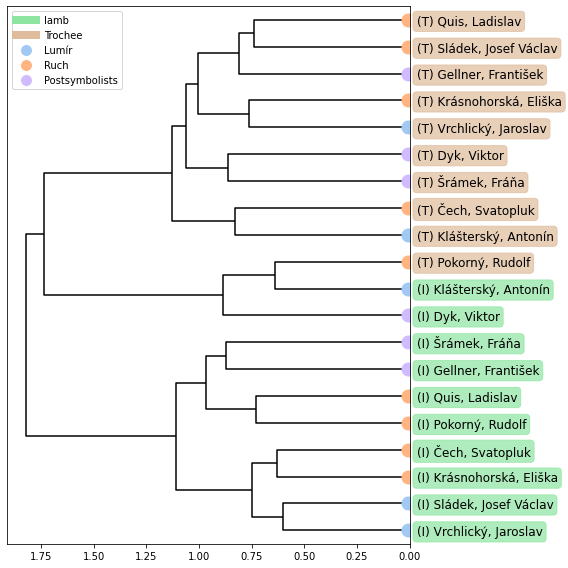

In [493]:
# Bin to store 
counts = defaultdict(dict)
# Bin to store data for individual authors
dfs = list()
# List of authors excluding decadents
authors_ = authors['LUM']+authors['RUC']+authors['POS']
    
# Iterate over authors
for a in authors_:
    # Keep only poems by current author
    dfa = df[df.index.get_level_values('authors') == a] 
    # Z-score transformation
    dfa = zscore_transformation(dfa)                
    # Keep only selected meters
    dfa = dfa[dfa.index.get_level_values('m_families').isin(['I', 'T'])]    
    # Count poems
    for m in ('I', 'T'):
        dfc = dfa[dfa.index.get_level_values('m_families') == m] 
        counts[a][m] = len(dfc.index)
    # Get mean values for each meters
    dfa = dfa.groupby(['m_families']).mean()
    dfa = pd.concat([dfa], keys=[re.sub(',asdasd.*$', '', a)], names=['authors'])
    # Append df to the list
    dfs.append(dfa)

# Concatenate dataframes
dfm = pd.concat(dfs)
    
# Remove authors having less than required number of poems in one of the meters
for a in counts:
    for m in counts[a]:
        if counts[a][m] < 50:
            dfm = dfm[dfm.index.get_level_values('authors') != a]              
                
# Plot dendrogram
dfm.index = ['({0}) {1}'.format(idx[1], idx[0]) for idx in dfm.index]    
colors = {'I':"#8DE5A1", 'T': "#DEBB9B",}
cols = dict()
for a in list(dfm.index):
    cols[a] = colors[a[1]]
legend = [
    ['Iamb', 'Trochee', 'Lumír', 'Ruch', 'Postsymbolists'], 
    ['#8DE5A1', '#DEBB9B', '#a1c9f4','#ffb482', '#d0bbff'],
    ['bbox', 'bbox', 'circle', 'circle', 'circle']
]
cluster_labels = {
    'x'       : [0.008]*20,
    'y'       : (5,15,25,35,45,55,65,75,85,95,105,115,125,135,145,155,165,175,185,195),
    'colors'  : [
        '#a1c9f4','#a1c9f4','#ffb482','#ffb482','#ffb482','#ffb482', '#d0bbff', '#d0bbff', '#d0bbff',
        '#a1c9f4','#ffb482', '#a1c9f4','#ffb482', '#d0bbff', '#d0bbff', '#a1c9f4','#ffb482', '#d0bbff',
        '#ffb482','#ffb482'
    ],
    'text'    : ['']*20,
    'fontsize': 8,
} 
plot_dendrogram(
    dfm, 'cosine', 'complete', level=0, colors=cols, figsize=(8,8), 
    cluster_labels=cluster_labels, legend=legend, filename='topics_meters',
)
plt.show()

<h3>SVM - meter recognition based on topics</h3>

In [528]:
#============================================
# Number of random samples per each author
n_samples   = 15
# Sample size
sample_size = 20
# Number of iterations
iterations = 10000
#============================================

# Initialize the classifier
clf = SVC(kernel='linear', C=1)

# Bins to store accuracy scores and feature importances
accuracy    = defaultdict(lambda: defaultdict(list))
importances = defaultdict(list)

# Limit df to LUM, RUC and POS authors
df1 = df[df.index.get_level_values('authors').isin(authors_)]

# Perform requested number of iterations
for iteration in range(iterations):
    print('{}/{}{}'.format(iteration+1, iterations, ' '*20), end='\r')
    # Bin to store random samples
    samples = dict()
    # Iterate over groups
    for group in ('LUM', 'RUC', 'POS'):
        # Bin to store z-scores for poems by authors from current group
        dfs = list()
        # Iterate over authors
        for a in authors[group]:
            # Keep only poems by current authors
            dfa = df1[df1.index.get_level_values('authors') == a] 
            # Z-score transformation
            dfa = zscore_transformation(dfa)                
            # Keep only selected meters
            dfa = dfa[dfa.index.get_level_values('m_families').isin(['I', 'T'])]   
            # Append df to the list
            dfs.append(dfa)
        # Concatenate group into single dataframe
        dfm = pd.concat(dfs)
    
        #
        # Sampling
        #

        # Bin to store author samples
        samples[group] = list()
        # Iterate over meters
        for meter in ('I', 'T'):
            # Keep only poems in current meter
            df_single = dfm[dfm.index.get_level_values('m_families') == meter]
            # Shuffle dataframe
            df_single = df_single.sample(frac=1)
            # Iteratively extract samples
            for ii in range(n_samples):
                # Extract sample
                sample = df_single[ii*sample_size:(ii+1)*sample_size]
                # Average the values in sample
                sample_mean = sample.groupby(['m_families']).mean()
                # Add sample to the list
                samples[group].append(sample_mean)                
        # Concat samples into single dataframe
        samples[group] = pd.concat([x for x in samples[group]])

        #
        # Classification
        # 

        # Get numpy array holding vectors (X) and corresponding classes (y)
        X = samples[group].values
        y = list(samples[group].index.get_level_values('m_families'))
        # Get leave one out splits
        loo = LeaveOneOut()
        loo.get_n_splits(X)
        # Bin to store number of successes / trials
        suc_trials = [0,0]
        # Iterate over loo splits
        for train_index, test_index in loo.split(X):
            # Split to train set and test set
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
            # Train the model
            clf.fit(X_train, y_train)
            # Perform classification
            predicted = clf.predict(X_test)
            # Increase the number of trials
            suc_trials[1] += 1
            # Increase the number of successes if classification correct
            if predicted[0] == y_test[0]:
                suc_trials[0] += 1
        # Calculate accuracy in current iteration
        acc = suc_trials[0]/suc_trials[1]
        # Append accuracy to the bin
        accuracy[group][group].append(acc)

        #
        # Feature importances
        #

        # Fit classifier to all data
        model = clf.fit(X, np.array(y))
        dfi = pd.Series(list(model.coef_[0]), list(dfa.columns))
        # Append importances to the bin
        importances[group].append(dfi) 
        
    #
    # Cross-group classification
    #
    
    # Iterate over group-pairs
    for pair in (
        ('LUM','RUC'), ('RUC', 'LUM'), ('LUM', 'POS'), ('POS', 'LUM'), ('RUC','POS'), ('POS','RUC')
    ):
        # Get numpy array holding vectors (X) and corresponding classes (y)
        X_train = samples[pair[0]].values
        y_train = list(samples[pair[0]].index.get_level_values('m_families'))
        X_test = samples[pair[1]].values
        y_test = list(samples[pair[1]].index.get_level_values('m_families'))
        # Fit classifier to train set
        clf.fit(X_train, y_train)
        # Perform classification
        predicted = clf.predict(X_test)
        # Calculate accuracy
        acc = 0
        for pred, real in zip(predicted, y_test):
            # Increase the number of successes if classification correct
            if pred == real:
                acc += 1/len(y_test)
        accuracy[pair[0]][pair[1]].append(acc)

In [529]:
#
# Average accuracy values
#

# Iterate over train sets
for group1 in accuracy:
    # Iterate over test sets
    for group2 in accuracy:
        # Print average accuracy and standard deviation
        print(
            group1, group2, 'ACC(mean) =', np.mean(accuracy[group1][group2]),
            ' ACC(std) =', np.std(accuracy[group1][group2])
        )

LUM LUM ACC(mean) = 0.7079333333333334  ACC(std) = 0.11143785512811864
LUM RUC ACC(mean) = 0.6724333333333332  ACC(std) = 0.08534290961891455
LUM POS ACC(mean) = 0.5945866666666666  ACC(std) = 0.09530900761907729
RUC LUM ACC(mean) = 0.6623366666666665  ACC(std) = 0.08894708782941313
RUC RUC ACC(mean) = 0.7726833333333334  ACC(std) = 0.09934854329860887
RUC POS ACC(mean) = 0.6632799999999999  ACC(std) = 0.08545354449446006
POS LUM ACC(mean) = 0.5972933333333332  ACC(std) = 0.08732065149652617
POS RUC ACC(mean) = 0.6576199999999998  ACC(std) = 0.07676907681844009
POS POS ACC(mean) = 0.8027000000000001  ACC(std) = 0.09120330768855556


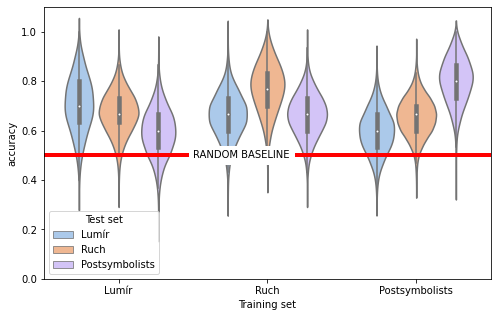

In [551]:
#
# Plot accuracy values
#

# Random baseline
rb = 0.5
# Labels to be used in chart
full_labels = {'LUM': 'Lumír', 'RUC': 'Ruch', 'POS': 'Postsymbolists',}
# Accuracy values to df
df_data = []
for group1 in ('LUM', 'RUC', 'POS'):
    for group2 in ('LUM', 'RUC', 'POS'):
        for a in accuracy[group1][group2]:
            df_data.append([a, full_labels[group1], full_labels[group2]])
df_data = pd.DataFrame(df_data, columns=['accuracy', 'Training set', 'Test set'])
# Plot chart
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax = sns.violinplot(x="Training set", y="accuracy", hue="Test set",
                    data=df_data, palette=['#a1c9f4','#ffb482', '#d0bbff'], bw=0.25)
ax.set_ylim((0,1.1))
plt.axhline(linewidth=4, y=rb, color='red')
plt.text(0.5, rb, 'RANDOM BASELINE', fontsize=10, va='center', ha='left', backgroundcolor='w')
fig.savefig('fig/svm2.pdf', dpi="figure")

In [559]:
#
# Print feature importances
#

for group in importances:
    print('\n{0}\n     {1}\n{0}\n'.format('='*15, group))
    fi = reduce(lambda a, b: a.add(b, fill_value=0), importances[group]).div(iterations).sort_values()
    print('-'*30, 'I', '-'*30)
    print(fi.head(5))
    print('-'*30, 'T', '-'*30)
    print(fi.tail(5)[::-1])


     LUM

------------------------------ I ------------------------------
(83) zřít - zrak - skráň - tvář - sen         -0.480912
(50) věk - sláva - velký - lidstvo - slavný   -0.310614
(73) krása - umění - tvar - luzný - barva     -0.255431
(29) krev - hrůza - smrt - zloba - vrah       -0.192415
(94) perla - zlatý - víla - ňadro - květ      -0.179606
dtype: float64
------------------------------ T ------------------------------
(67) císař - Řím - dát - bůh - jít           0.432529
(33) hoch - dívka - děvče - mladý - děva     0.295823
(8) pán - pan - věc - moudrý - rada          0.231411
(9) boj - vojsko - meč - zbraň - rek         0.200732
(52) starý - nový - mladý - pěkný - škola    0.199330
dtype: float64

     RUC

------------------------------ I ------------------------------
(50) věk - sláva - velký - lidstvo - slavný     -0.525801
(83) zřít - zrak - skráň - tvář - sen           -0.515472
(9) boj - vojsko - meč - zbraň - rek            -0.327346
(88) lid - národ - svoboda - pra

In [541]:
en_topics = '''001 & rok, čas, doba, den, dlouhý & year, time, period/age, day, long\\
002 & žena, muž, družka, mladý, krásný & woman, man, partner, young, beautiful\\
003 & les, strom, větev, mech, tráva & forest, tree, branch, moss, grass\\
004 & říci, ptát, vědět, povědět, dít & to say, to ask, to know, to tell, to tell\\
005 & hlad, bída, chudý, chléb, bídný & hunger, poverty, poor, bread, woeful\\
006 & boží, Kristus, anděl, kříž, panna & godly, Christ, angel, cross, virgin\\
007 & hrob, mrtvý, rakev, ležet, smrt & grave, dead, coffin, to lie, death\\
008 & zvolat, tvář, velký, stát, síň & to exclaim, face, big, to stand, hall\\
009 & pán, pan, věc, moudrý, rada & sir, man, thing, wise, advice\\
010 & boj, vojsko, meč, zbraň, rek & fight, army, sword, weapon, hero\\
011 & hrát, smát, tančit, hra, kolo & to play, to laugh, to dance, game, circle\\
012 & dlít, modlit, prosit, modlitba, nosit & to dwell, to pray, to beg, prayer, to carry\\
013 & krásný, kvítek, háj, sladký, slunko & beautiful, flower, grove, sweet, sun\\
014 & svět, celý, jiný, umět, znát & world, whole, other, be able to, to know\\
015 & voda, řeka, jezero, proud, břeh & water, river, lake, stream, bank\\
016 & kůň, hnát, běžet, skok, jet & horse, to drive/hurry, to run, jump, to drive\\
017 & pes, jet, vůz, zub, kost & dog, to drive, wagon, tooth, bone\\
018 & milovat, svatý, učit, milenec, znát & to love, saint, to teach, lover, to know\\
019 & prach, déšť, kámen, padat, krůpěj & dust, rain, stone, to fall, bead\\
020 & kraj, cizí, vrátit, domov, rodný & region, strange, to return, home, home/birth\\
021 & noc, tma, měsíc, světlo, luna & night, dark, moon, light, moon\\
022 & moci, muset, lze, smět, možný & to be allowed, to have to, to be possible, to be allowed, possible\\
023 & sen, mládí, snít, pohádka, duše & dream, youth, to dream, fairytale, soul\\
024 & slovo, jediný, mluvit, němý, řeč & word, single, to speak, voiceless\\
025 & pít, víno, číše, číš, pohár & to drink, wine, goblet, goblet, cup\\
026 & sníh, mráz, zima, led, bílý & snow, frost, winter, ice, white\\
027 & věřit, přítel, druh, vzpomenout, jméno & to believe, friend, companion, to remember, name\\
028 & pravda, klam, víra, lež, blud & truth, illusion, faith, lie, fallacy\\
029 & Jan, Praha, mistr, vůdce, strana & John, Prague, master, leader, side/party\\
030 & krev, hrůza, smrt, zloba, vrah & blood, fear, death, anger, murderer\\
031 & ret, sladký, láska, líbat, polibek & lip, sweet, love, to kiss, kiss\\
032 & milý, drahý, plakat, milá, sejít & boyfriend, dear, to cry, girlfirend, to meet\\
033 & věčný, duše, duch, nebeský, svět & eternal, soul, spirit, heavenly, world\\
034 & hoch, dívka, děvče, mladý, děva & boy, girl, girl, young, girl\\
035 & přijít, čekat, přicházet, vejít, toužit & to come, to wait, to be comming, to enter, to long for\\
036 & stín, duše, večer, mlha, šero & shaddow, soul, evening, fog, gloom\\
037 & bratr, sestra, patřit, chvála, druhý & brother, sister, to belong, praise, second\\
038 & život, žití, smrt, duše, trud & life, living, death, soul, grief\\
039 & chtít, vědět, rád, znát, toužit & to want, to know, to be pleased, to know, to long for\\
040 & matka, matička, dítě, máť, otec & mother, mother, child, mother, father\\
041 & pole, klas, lán, plod, zrát & field, ear, field, fruit, to ripen\\
042 & bůh, nebe, chránit, dát, tvořit & God, heaven, to protect, to give, to create\\
043 & ruka, oko, hlava, chtít, jít & hand, eye, head, to want, to go\\
044 & slza, žal, pláč, lkát, plakat & tear, grief, cry, to wail\\
045 & pták, letět, křídlo, hnízdo, motýl & bird, to fly, wing, nest, butterfly\\
046 & člověk, lidský, lidstvo, tvor, země & man, human, humanity, creature, Earth\\
047 & ctnost, dobrý, přát, blaho, milost & virtue, good, to wish, bliss, mercy\\
048 & slunce, hora, modrý, kraj, bílý & sun, mount, blue, region, white\\
049 & píseň, zpívat, pět, zpěv, slavík & song, to sing, to sing, singing, nightingale\\
050 & prostor, tajemný, věčnost, země, tajemství & space, mysterious, eternity, Earth, secret\\
051 & věk, sláva, velký, lidstvo, slavný & age, glory, big, humanity, famous\\
052 & oko, tvář, slovo, temný, hled & eye, cheek, word, dark, sight\\
053 & starý, nový, mladý, pěkný, škola & old, new, young, nice, school\\
054 & hledat, najít, poznat, ráj, ztratit & to search, to find, to get to know, Paradise, to loose\\
055 & chrám, kněz, kostel, oltář, sloup & temple, priest, church, altar, column\\
056 & chtít, říkat, dát, dostat, dělat & to want, to say, to give, to get, to do\\
057 & květ, jaro, vůně, slunce, duše & flower, spring, smell, sun, soul\\
058 & den, noc, spát, sen, spánek & day, night, to sleep, dream, sleep\\
059 & město, ulice, dům, věž, hluk & town, street, house, tower, noise\\
060 & okno, dveře, chata, ves, jizba & window, door, cottage, village, room\\
061 & bývat, zlato, obraz, marný, slepý & to be, gold, picture, vain, blind\\
062 & verš, básník, pero, báseň, psát & verse, poet, pen, poem, to write\\
063 & láska, srdce, milenka, věrný, Toba & love, heart, lover, faithful, Toba\\
064 & král, trůn, říše, pyšný, koruna & king, throne, empire, proud, crown\\
065 & síla, práce, silný, dílo, ruka & power, labour, strong, work, hand\\
066 & moře, loď, vlna, břeh, plout & sea, boat, wave, shore/bank, to sail\\
067 & cesta, jít, krok, kráčet, poutník & road, to go, step, to walk, pilgrim\\
068 & císař, Řím, dát, bůh, jít & emperor, Rome, to give, god, to go\\
069 & dítě, malý, dětský, děcko, velký & child, small, childish, kid, big\\
070 & hvězda, nebe, nechat, slunce, svítit & star, sky, to leave, sun, to shine\\
071 & hlava, ruka, vlas, bílý, zlatý & head, hand, hair, white, golden\\
072 & mnohý, peklo, čert, ďábel, držet & many, hell, devil, devil, to hold\\
073 & osud, cíl, dojít, zhynout, pouť & fate, goal, to arrive, to die, journey\\
074 & krása, umění, tvar, luzný, barva & beauty, art, shape, charming\\
075 & podzim, listí, strom, léto, větev & autumn, leaves, tree, summer, branch\\
076 & paní, choť, dcera, síť, krásný & lady, wife, daughter, net, beauty\\
077 & pouto, volný, otrok, divoký, svoboda & shackles, free, slave, wild, freedom\\
078 & vlast, český, Čech, národ, Čechy & motherland, Czech, Czech, nation, Bohemia\\
079 & otec, syn, vina, hřích, rod & father, son, blame, sin, family\\
080 & žít, pěvec, poezie, bít, krýt & to live, singer, poetry, to beat, to cover\\
081 & černý, vítr, vát, mrak, kvílet & black, wind, to blow, cloud, to howl\\
082 & oko, vidět, hledět, dívat, tvář & eye, to see, to watch, to look, face\\
083 & plamen, oheň, žhavý, krev, žár & flame, fire, hot, blood, heat\\
084 & zřít, zrak, skráň, tvář, sen & to see, sight, cheek, face, dream\\
085 & srdce, duše, cit, cítit, tlouci & heart, soul, feeling, to feel, to beat\\
086 & kniha, číst, psát, list, jistý & book, read, write, leaf, certain\\
087 & pustý, poušť, písek, lev, křičet & deserted, desert, sand, lion, to scream\\
088 & jít, stádo, volat, viz, bílý & to go, herd, to call, to see, white\\
089 & lid, národ, svoboda, prapor, volnost & people, nation, freedom, flag, liberty\\
090 & duše, smutek, bolest, smutný, srdce & soul, sadness, pain, sad, heart\\
091 & dát, vzít, dar, poslat, zdravý & to give, to take, present, to send, healthy\\
092 & chtít, řád, kázat, sloužit, právo & to want, code, to preach, to serve, law\\
093 & znít, slyšet, hlas, zvuk, zvon & to sound, to hear, voice, sound, bell\\
094 & růže, kvést, růž, květ, keř & rose, to bloom, red, flower, bush\\
095 & perla, zlatý, víla, ňadro, květ & pearl, golden, nymph, breast, flower\\
096 & smích, radost, ples, veselý, smát & laughter, joy, ball, cheery, to laugh\\
097 & hrad, královna, rytíř, kníže, zámek & castle, queen, knight, prince, castle\\
098 & lampa, síň, kout, stařec, stěna & lamp, hall, corner, old man, wall\\
099 & skála, hora, bouře, blesk, hřmít & rock, mountain, storm, lightning, to thunder\\
100 & srdce, bůh, svět, ctnost, krása & heart, god, world, virtue, beauty\\'''   
en_topics = en_topics.split('\n')
en_topics_dict = dict()
for i,t in enumerate(en_topics):
    en_topics[i] = re.sub(r'^([0-9]+) \&.*\& (.*)\\', r'\1 & \2', t)
    key = str(int(t[0:3]))
    en_topics_dict[key] = en_topics[i]

#
# Print feature importances (LaTeX)
#
from functools import reduce
fis = dict()
for group in importances:
    print('\midrule')
    if group == 'LUM':
        print('\\multicolumn{4}{c}{Lumír} \\\\')
    elif group == 'RUC':
        print('\\multicolumn{4}{c}{Ruch} \\\\')
    else:
        print('\\multicolumn{4}{c}{Postsymoblists} \\\\')
    print('\\multicolumn{2}{c}{Iamb} & \\multicolumn{2}{c}{Trochee}\\\\')
    print('\\midrule')
    fi = reduce(lambda a, b: a.add(b, fill_value=0), importances[group]).div(iterations).sort_values()
    it = fi.index.to_list()[:5]
    tt = fi.index.to_list()[-5:]
    tt.reverse()
    for x,y in zip(it,tt):
        ite = str(int(re.sub(r'\(([0-9]+)\).*$', r'\1', x))+1)
        tte = str(int(re.sub(r'\(([0-9]+)\).*$', r'\1', y))+1)        
        print(en_topics_dict[ite] + ' & ' + en_topics_dict[tte] +'\\\\')


\midrule
\multicolumn{4}{c}{Lumír} \\
\multicolumn{2}{c}{Iamb} & \multicolumn{2}{c}{Trochee}\\
\midrule
084 & to see, sight, cheek, face, dream & 068 & emperor, Rome, to give, god, to go\\
051 & age, glory, big, humanity, famous & 034 & boy, girl, girl, young, girl\\
074 & beauty, art, shape, charming & 009 & sir, man, thing, wise, advice\\
030 & blood, fear, death, anger, murderer & 010 & fight, army, sword, weapon, hero\\
095 & pearl, golden, nymph, breast, flower & 053 & old, new, young, nice, school\\
\midrule
\multicolumn{4}{c}{Ruch} \\
\multicolumn{2}{c}{Iamb} & \multicolumn{2}{c}{Trochee}\\
\midrule
051 & age, glory, big, humanity, famous & 032 & boyfriend, dear, to cry, girlfirend, to meet\\
084 & to see, sight, cheek, face, dream & 071 & head, hand, hair, white, golden\\
010 & fight, army, sword, weapon, hero & 001 & year, time, period/age, day, long\\
089 & people, nation, freedom, flag, liberty & 009 & sir, man, thing, wise, advice\\
052 & eye, cheek, word, dark, sight & 060

In [533]:
for x in (('L','R'), ('R', 'B'), ('L', 'B')):
    dist = (np.linalg.norm(df_m[x[0]]-df_m[x[1]]))
    print(x, dist)

('L', 'R') 1.4793781180092667
('R', 'B') 1.887017632193255
('L', 'B') 1.8894326668392265


In [534]:
from scipy import spatial

dists = defaultdict(list)

for pair in (('LUM','RUC'), ('RUC', 'POS'), ('LUM', 'POS')):
    for i,x in enumerate(importances[pair[0]]):
        #dists[pair].append(spatial.distance.cosine(importances[pair[0]][i], importances[pair[1]][i]))
        #dists[pair].append(np.linalg.norm(importances[pair[0]][i]-importances[pair[1]][i]))
        dists[pair].append(scipy.stats.pearsonr(importances[pair[0]][i], importances[pair[1]][i])[0])
for pair in dists:
    print(pair, np.mean(dists[pair]), np.std(dists[pair]))

('LUM', 'RUC') 0.17417067340829884 0.09318947674142943
('RUC', 'POS') 0.16784797920893624 0.0836737617820097
('LUM', 'POS') 0.09444943450144537 0.09168013957676797


In [540]:

for group in ('LUM', 'RUC'):
    # Reduce df to given group
    dfa = df[df.index.get_level_values('authors').isin(authors[group])]
    # Transform to dict
    d = dfa.to_dict()
    vectors = defaultdict(list)
    for x in d :
        for y in sorted(d[x]):
            vectors[x].append(d[x][y])
    # Calculate Pearson's R between topic #9 and all remaining topics
    weights = dict()
    for x in vectors:
        if x == '(9) boj - vojsko - meč - zbraň - rek':
            continue
        weights[x] = scipy.stats.pearsonr(
            vectors['(9) boj - vojsko - meč - zbraň - rek'], vectors[x]
        )[0]
    # Print top 10 topics
    print('\n{0} {1} {0}\n'.format('='*10, group))
    i = 0
    for x in sorted(weights, key=weights.get, reverse=True):
        print(x, weights[x])
        i += 1
        if i == 10:
            break


========== LUM ==========

(67) císař - Řím - dát - bůh - jít 0.1472952014740609
(63) král - trůn - říše - pyšný - koruna 0.12749587001110319
(77) vlast - český - Čech - národ - Čechy 0.12461569113960382
(78) otec - syn - vina - hřích - rod 0.07681357898925985
(91) chtít - řád - kázat - sloužit - právo 0.07206249255490596
(88) lid - národ - svoboda - prapor - volnost 0.06183258821477994
(15) kůň - hnát - běžet - skok - jet 0.06013457805059461
(29) krev - hrůza - smrt - zloba - vrah 0.05858251249830187
(96) hrad - královna - rytíř - kníže - zámek 0.033638912026520244
(76) pouto - volný - otrok - divoký - svoboda 0.030035282070006532

========== RUC ==========

(29) krev - hrůza - smrt - zloba - vrah 0.11158905286541591
(50) věk - sláva - velký - lidstvo - slavný 0.09501352807213276
(64) síla - práce - silný - dílo - ruka 0.06504430602007903
(83) zřít - zrak - skráň - tvář - sen 0.051203027505404064
(76) pouto - volný - otrok - divoký - svoboda 0.0459220817661881
(98) skála - hora - bou

In [38]:
import json 
import re
from collections import defaultdict

authors = {
    'LUM': [ 'Kučera, Karel', 'Kvapil, František', 'Vrchlický, Jaroslav', 
            'Sládek, Josef Václav', 'Zeyer, Julius', 'Klášterský, Antonín'],
    'RUC': ['Krásnohorská, Eliška', 'Pokorný, Rudolf', 'Čech, Svatopluk', 'Quis, Ladislav'],
    'DEC': ['Auředníček, Otakar', 'Borecký, Jaromír', 'Hašek, Roman', 'Rožek, Karel', 
            'Hendrych, Jaroslav', 'Nejč, Karel', 'Ráž, Arnošt', 'Bíbl, František',
            'Gintl, Zdeněk', 'Rosenzweig-Moir, Josef', 'Karásek ze Lvovic, Jiří', 'Březina, Otokar', 
            'Hlaváček, Karel'],
    'POS': ['Toman, Karel', 'Gellner, František', 'Šrámek, Fráňa', 'Dyk, Viktor'],
}

# Load data on topics
with open ('corpora/cs.json') as file:
    data = json.load(file)
    
scores = list()
scores2 = defaultdict(lambda: defaultdict(list))
    
for author, pos_tags, meter, n in zip(data['authors'], data['pos_tags'], data['meters'], data['n_lines']):
    
    if n > 100:
        continue
    
    if author in authors['LUM']:
        group = 'LUM'
    elif author in authors['RUC']:
        group = 'RUC'
    elif author in authors['POS']:
        group = 'POS'
    else:
        continue
        
    met = ''.join(sorted([re.sub('[0-9]+', '', x) for x in meter]))
    met = re.sub('I+', 'I', met)
    met = re.sub('T+', 'T', met)   
    if met not in ('I', 'T'):
        continue

    q = [0,0]
    
    for pos in pos_tags:
        if pos.startswith('V'):
            q[0] += 1
        if pos.startswith('A'): #, 'N'):
            q[1] += 1
            
    if q[1] == 0:
        continue
            
    q = q[0] / (q[0] + q[1])
    
    scores.append([group, met, q])
    scores2[group][met].append(q)

(0.0, 1.0)

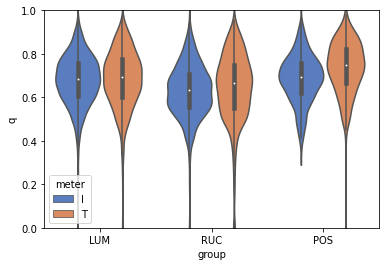

In [33]:
import pandas as pd
import seaborn as sns
scores = pd.DataFrame(scores, columns=['group', 'meter', 'q'])
ax = sns.violinplot(x="group", y="q", hue="meter",
                    data=scores, palette="muted")
ax.set_ylim([0,1])

In [54]:
import numpy as np
from scipy import stats
import pingouin as pg


for g in scores2:
    print(len(scores2[g]['T']+scores2[g]['I'])-2)
    for m in scores2[g]:
        print(g, m, np.mean(scores2[g][m]), np.std(scores2[g][m]))
    print(stats.ttest_ind(scores2[g]['T'], scores2[g]['I']))
    print(pg.compute_effsize(scores2[g]['T'], scores2[g]['I'], paired=False, eftype='cohen'))

7482
LUM I 0.6794432392603944 0.11604046349725385
LUM T 0.6838805378205707 0.13230463788187163
Ttest_indResult(statistic=1.379621232854882, pvalue=0.16774452513141883)
0.03688192148842042
1545
RUC T 0.6449496767941074 0.15735667615506954
RUC I 0.6302606997196986 0.12074416921376274
Ttest_indResult(statistic=2.006099263686153, pvalue=0.045019692242735714)
0.10291632320848434
1210
POS I 0.6856271948602051 0.10998032260333533
POS T 0.7353817906011164 0.12178363372309921
Ttest_indResult(statistic=6.750884461322761, pvalue=2.2747450682341346e-11)
0.43902479221268387
